### imports and preprocessing

In [52]:
import pandas as pd
import numpy as np


In [53]:
import pandas as pd

df = pd.read_csv('../Data/predictive_data/districtwise_sum_monthly_demo.csv')
df

,state_clean,district_clean,date,total_demographic
0,Andaman and Nicobar Islands,Andamans,2025-09,114
1,Andaman and Nicobar Islands,Andamans,2025-10,66
2,Andaman and Nicobar Islands,Andamans,2025-11,162
3,Andaman and Nicobar Islands,Andamans,2025-12,213
4,Andaman and Nicobar Islands,Nicobar,2025-03,196
...,...,...,...,...
5242,West Bengal,Uttar Dinajpur,2025-12,21107
5243,West Bengal,West Medinipur,2025-09,5
5244,West Bengal,West Medinipur,2025-10,1
5245,West Bengal,West Medinipur,2025-11,1


In [54]:
df = df.rename(columns={'date': 'month',
                        'state_clean':'state',
                        'district_clean' : 'district',
                        })
df.head()

,state,district,month,total_demographic
0,Andaman and Nicobar Islands,Andamans,2025-09,114
1,Andaman and Nicobar Islands,Andamans,2025-10,66
2,Andaman and Nicobar Islands,Andamans,2025-11,162
3,Andaman and Nicobar Islands,Andamans,2025-12,213
4,Andaman and Nicobar Islands,Nicobar,2025-03,196


In [55]:
df['month'] = pd.to_datetime(df['month'])

df['year'] = df['month'].dt.year
df['month_num'] = df['month'].dt.month

df = df.sort_values(['state', 'district', 'month']).reset_index(drop=True)
df.head()

,state,district,month,total_demographic,year,month_num
0,Andaman and Nicobar Islands,Andamans,2025-09-01,114,2025,9
1,Andaman and Nicobar Islands,Andamans,2025-10-01,66,2025,10
2,Andaman and Nicobar Islands,Andamans,2025-11-01,162,2025,11
3,Andaman and Nicobar Islands,Andamans,2025-12-01,213,2025,12
4,Andaman and Nicobar Islands,Nicobar,2025-03-01,196,2025,3


In [56]:
counts = (
    df.groupby(['state', 'district'])
      .size()
      .reset_index(name='n_months')
)
counts


,state,district,n_months
0,Andaman and Nicobar Islands,Andamans,4
1,Andaman and Nicobar Islands,Nicobar,5
2,Andaman and Nicobar Islands,North And Middle Andaman,6
3,Andaman and Nicobar Islands,South Andaman,5
4,Andhra Pradesh,Adilabad,5
...,...,...,...
859,West Bengal,Puruliya,9
860,West Bengal,South Dinajpur,4
861,West Bengal,South DumDum(M),4
862,West Bengal,Uttar Dinajpur,9


In [57]:
valid_keys = counts.query("n_months >= 3")[['state', 'district']]
valid_keys = set(map(tuple, valid_keys.values))

df = df[
    df[['state', 'district']]
    .apply(tuple, axis=1)
    .isin(valid_keys)
].copy()
df.head()


,state,district,month,total_demographic,year,month_num
0,Andaman and Nicobar Islands,Andamans,2025-09-01,114,2025,9
1,Andaman and Nicobar Islands,Andamans,2025-10-01,66,2025,10
2,Andaman and Nicobar Islands,Andamans,2025-11-01,162,2025,11
3,Andaman and Nicobar Islands,Andamans,2025-12-01,213,2025,12
4,Andaman and Nicobar Islands,Nicobar,2025-03-01,196,2025,3


In [58]:
df = df.sort_values(['state', 'district', 'month'])
df.head()


,state,district,month,total_demographic,year,month_num
0,Andaman and Nicobar Islands,Andamans,2025-09-01,114,2025,9
1,Andaman and Nicobar Islands,Andamans,2025-10-01,66,2025,10
2,Andaman and Nicobar Islands,Andamans,2025-11-01,162,2025,11
3,Andaman and Nicobar Islands,Andamans,2025-12-01,213,2025,12
4,Andaman and Nicobar Islands,Nicobar,2025-03-01,196,2025,3


### feature creation

In [59]:
df['lag_1'] = (
    df.groupby(['state', 'district'])['total_demographic']
      .shift(1)
)


In [60]:
df = df.dropna(subset=['lag_1']).reset_index(drop=True)


In [61]:
# Add this during your feature engineering step
df['diff_1'] = df.groupby(['state', 'district'])['lag_1'].diff()
df['diff_2'] = df.groupby(['state','district'])['diff_1'].diff()
# Add 'diff_1' to your num_features list

In [62]:
# Group by district to make sure lags don't 'leak' from other districts
df = df.sort_values(['district', 'month_num'])

# 1. Rolling Average (Smooths out random monthly spikes)
df['rolling_3'] = df.groupby('district')['lag_1'].transform(lambda x: x.rolling(window=3).mean())

# 2. Momentum/Trend (Is enrollment increasing or decreasing?)
df['trend_diff'] = df.groupby('district')['lag_1'].diff()

# 3. Year-over-Year (If you have 12+ months of data)
# df['lag_12'] = df.groupby('district')['enrollment'].shift(12)

# Fill NaNs created by shifting
df = df.fillna(0)

### train test splits

In [63]:
train_parts, test_parts = [], []

for _, g in df.groupby(['state', 'district']):
    if len(g) < 2:
        continue
    train_parts.append(g.iloc[:-1])
    test_parts.append(g.iloc[-1:])


In [64]:
train_df = pd.concat(train_parts).reset_index(drop=True)
test_df  = pd.concat(test_parts).reset_index(drop=True)


In [65]:
assert set(zip(test_df.state, test_df.district)).issubset(
       set(zip(train_df.state, train_df.district))
)


In [66]:
features = ['state', 'district', 'month_num', 'lag_1','rolling_3','trend_diff','diff_1','diff_2']

X_train = train_df[features]
y_train = train_df['total_demographic']

X_test  = test_df[features]
y_test  = test_df['total_demographic']


In [67]:
# 1. Convert to category type instead of OneHotEncoding
X_train['state'] = X_train['state'].astype('category')
X_train['district'] = X_train['district'].astype('category')
X_test['state'] = X_test['state'].astype('category')
X_test['district'] = X_test['district'].astype('category')



C:\Users\PC\AppData\Local\Temp\ipykernel_8516\3954644134.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['state'] = X_train['state'].astype('category')
C:\Users\PC\AppData\Local\Temp\ipykernel_8516\3954644134.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['district'] = X_train['district'].astype('category')
C:\Users\PC\AppData\Local\Temp\ipykernel_8516\3954644134.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

### Model training 

In [68]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from lightgbm import LGBMRegressor

# 1. Define Features
cat_features = ['state', 'district']
num_features = ['month_num', 'lag_1','diff_1','rolling_3','trend_diff','diff_2']

# 2. Use OrdinalEncoder (Better for LightGBM than OneHot)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_features),
        ('num', 'passthrough', num_features)
    ]
)

# 3. Adjust Model Hyperparameters for small/sparse data
model = LGBMRegressor(
    n_estimators=100,         # Lower to prevent overfitting
    learning_rate=0.05,
    max_depth=2,              # Shallow trees for small datasets
    min_child_samples=5,      # IMPORTANT: Reduced from 20 to allow splitting on small groups
    importance_type='gain',
    random_state=42,
    verbose=-1                # This turns off those 'No further splits' warnings
)

pipe = Pipeline([
    ('prep', preprocessor),
    ('model', model)
])
pipe.set_output(transform="pandas")

# 1. Transform the target
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# 2. Fit the pipeline on log data
pipe.fit(X_train, y_train_log)

# 3. Predict and transform back to original scale
y_pred_log = pipe.predict(X_test)
y_pred = np.expm1(y_pred_log)

# 4. Now calculate metrics using the original scale
from sklearn.metrics import mean_absolute_error, r2_score
print(f"New MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"New R²: {r2_score(y_test, y_pred)}")

New MAE: 2208.775510139658
New R²: 0.7364196784563153


In [69]:
import joblib

# 'pipe' is the name of the pipeline variable we created earlier
joblib.dump(pipe, 'demographic_model_v1.pkl')

print("Model saved")

Model saved


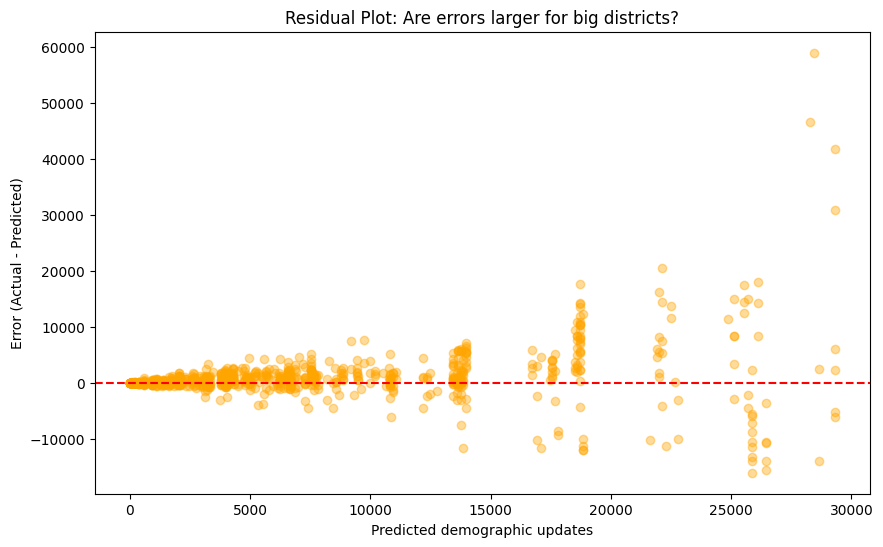

In [70]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, (y_test - y_pred), alpha=0.4, color='orange')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot: Are errors larger for big districts?')
plt.xlabel('Predicted demographic updates')
plt.ylabel('Error (Actual - Predicted)')
plt.show()

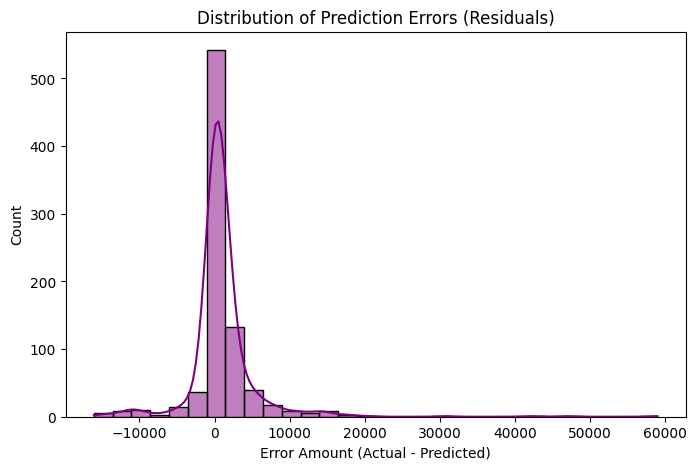

In [71]:
import seaborn as sns
errors = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=30, kde=True, color='purple')
plt.title('Distribution of Prediction Errors (Residuals)')
plt.xlabel('Error Amount (Actual - Predicted)')
plt.show()

### Predicting next month demographic updates for any district 

In [72]:
import pandas as pd
import numpy as np

def create_clean_data(df):
    # 1. Ensure date types are correct and sort
    # Assuming 'df' has 'state', 'district', 'month_num', and 'enrollment'
    df = df.sort_values(['district', 'month_num']).copy()

    # 2. Create Lag Feature (Last month's enrollment)
    df['lag_1'] = df.groupby('district')['total_demographic'].shift(1)

    # 3. Create Velocity (diff_1: Change from last month)
    df['diff_1'] = df.groupby('district')['lag_1'].diff()

    # 4. Create Acceleration (diff_2: Change of the change)
    df['diff_2'] = df.groupby('district')['diff_1'].diff()

    # 5. Create Rolling Mean (Average of last 3 months)
    df['rolling_3'] = df.groupby('district')['lag_1'].transform(lambda x: x.rolling(window=3).mean())

    # 6. Create Trend (How much it changed recently)
    df['trend_diff'] = df['diff_1']

    # 7. Final Cleaning: Remove rows where we don't have enough history to calculate lags
    # (The first 3 months of every district will usually be NaN)
    df_clean = df.dropna()

    return df_clean

# Apply the function
df_history = create_clean_data(df)

# Save it so your deployment code can find it
df_history.to_csv('cleaned_demographic_data.csv', index=False)
print("Clean data created and saved!")

Clean data created and saved!


In [73]:
import pandas as pd
import numpy as np
import joblib

# Load the saved pipeline and the historical data
# 'df_final' should be the dataframe you used for training
pipe = joblib.load('demographic_model_v1.pkl')
df_history = pd.read_csv('cleaned_demographic_data.csv')

def predict_next_month(state, district):
    # 1. Filter history for the specific district
    history = df_history[(df_history['state'] == state) &
                         (df_history['district'] == district)].sort_values('month_num')

    if len(history) < 3:
        return "Error: Not enough historical data for this district (Need at least 3 months)."

    # 2. Get the latest record to calculate features
    last_record = history.iloc[-1]
    prev_record = history.iloc[-2]

    # 3. Calculate features automatically
    current_lag_1 = last_record['total_demographic']
    current_diff_1 = last_record['total_demographic'] - prev_record['total_demographic']

    # Calculate acceleration (diff_2)
    prev_diff_1 = prev_record['total_demographic'] - history.iloc[-3]['total_demographic']
    current_diff_2 = current_diff_1 - prev_diff_1

    # Calculate rolling average of last 3 months
    current_rolling_3 = history.tail(3)['total_demographic'].mean()
    # Prepare the input for the model
    # We use Month 1 if last was 12, or last+1
    next_month_num = 1 if last_record['month_num'] == 12 else last_record['month_num'] + 1

    input_data = pd.DataFrame({
        'state': [state],
        'district': [district],
        'month_num': [next_month_num],
        'lag_1': [current_lag_1],
        'diff_1': [current_diff_1],
        'rolling_3': [current_rolling_3],
        'trend_diff': [current_diff_1], # using diff_1 as the trend
        'diff_2': [current_diff_2]
    })

    # 4. Predict and Inverse Log Transform
    pred_log = pipe.predict(input_data)
    prediction = np.expm1(pred_log)

    return int(prediction[0])

# --- Example Usage ---
# result = predict_next_month("Gujarat", "Ahmedabad")
# print(f"The predicted enrollment for next month is: {result}")

In [74]:
predict_next_month('Gujarat' , 'Surat')

9463

In [75]:
df_history[df_history['district']== 'Surat']

,state,district,month,total_demographic,year,month_num,lag_1,diff_1,diff_2,rolling_3,trend_diff
1724,Gujarat,Surat,2025-07-01,30546,2025,7,16743.0,-14246.0,-29184.0,21261.000000,-14246.0
1725,Gujarat,Surat,2025-09-01,27647,2025,9,30546.0,13803.0,28049.0,26092.666667,13803.0
1726,Gujarat,Surat,2025-10-01,12959,2025,10,27647.0,-2899.0,-16702.0,24978.666667,-2899.0
1727,Gujarat,Surat,2025-11-01,31421,2025,11,12959.0,-14688.0,-11789.0,23717.333333,-14688.0
1728,Gujarat,Surat,2025-12-01,44105,2025,12,31421.0,18462.0,33150.0,24009.000000,18462.0
